In [38]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')

%cd /content/drive/MyDrive/BME 450/Final Project/Ball


column_name = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
#column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.DataFrame()

df = df = pd.read_excel('Bungo.xlsx', names = column_name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BME 450/Final Project/Ball


In [39]:
from sklearn.preprocessing import MinMaxScaler

# df.replace(-9, pd.NA, inplace=True)
# df = df.apply(lambda x: x.fillna(int(x.mean())))

df_scaled = df.copy()
scaler = MinMaxScaler
for column in df:
  print(column)
  if(column != 'cardio'):
    min_val = df[column].min()
    max_val = df[column].max()
    #mean_val = df[column].mean()
    #std_val = df[column].std()

    #scaled_col = (df[column] - mean_val) / std_val
    scaled_col  = (df[column] - min_val) / (max_val - min_val)
    df_scaled[column] = scaled_col



df.loc[df['cardio'] > 0, 'cardio'] = 1

id
age
gender
height
weight
ap_hi
ap_lo
cholesterol
gluc
smoke
alco
active
cardio


In [40]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


train_df, test_df = train_test_split(df_scaled, test_size = 0.2)

train_features = train_df[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
test_features = test_df[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

train_tensor = torch.tensor(train_features.values, dtype=torch.float)
train_target = torch.tensor(train_df['cardio'].values, dtype=torch.long)

test_tensor = torch.tensor(test_features.values, dtype=torch.float)
test_target = torch.tensor(test_df['cardio'].values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_target)
test_dataset = TensorDataset(test_tensor, test_target)

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(12, 128)
        self.l2 = nn.Linear(128, 96)
        self.l3 = nn.Linear(96, 68)
        self.l4 = nn.Linear(68, 40)
        self.l5 = nn.Linear(40, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        output = self.l5(x)
        return output

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)

        # print(pred)
        # print(type(pred))
        # print(y)
        # print(type(y))
        #y = y.unsqueeze(1)
        # y = y.float()
        #y = y.view_as(pred)
        #y = y.float()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
#    return(loss)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #print(pred)
            # y = y.unsqueeze(1)
            # y = y.float()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return(test_loss, correct)


In [46]:
# training!

model = Net()

train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
learning_rate = 1e-3
batch_size = 1

#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

epochs = 100

test_loss_a = []
correct_a = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    [test_loss, correct] = test_loop(test_dataloader, model, loss_fn)

    test_loss_a.append(test_loss)
    correct_a.append(correct*100)

print("Done!")

Streaming output truncated to the last 5000 lines.
loss: 0.697184  [ 8401/56000]
loss: 0.382137  [ 8501/56000]
loss: 0.732427  [ 8601/56000]
loss: 0.511860  [ 8701/56000]
loss: 0.627864  [ 8801/56000]
loss: 0.450052  [ 8901/56000]
loss: 0.221435  [ 9001/56000]
loss: 1.139520  [ 9101/56000]
loss: 0.376213  [ 9201/56000]
loss: 0.588226  [ 9301/56000]
loss: 0.645390  [ 9401/56000]
loss: 0.813080  [ 9501/56000]
loss: 0.681495  [ 9601/56000]
loss: 1.015431  [ 9701/56000]
loss: 0.330919  [ 9801/56000]
loss: 1.002038  [ 9901/56000]
loss: 0.216181  [10001/56000]
loss: 0.626324  [10101/56000]
loss: 0.825693  [10201/56000]
loss: 0.383434  [10301/56000]
loss: 0.280083  [10401/56000]
loss: 0.521547  [10501/56000]
loss: 0.688597  [10601/56000]
loss: 0.352022  [10701/56000]
loss: 0.597811  [10801/56000]
loss: 0.334531  [10901/56000]
loss: 0.622277  [11001/56000]
loss: 0.400118  [11101/56000]
loss: 0.381148  [11201/56000]
loss: 0.770155  [11301/56000]
loss: 0.192954  [11401/56000]
loss: 0.248564  [11

Text(0, 0.5, 'Percent Correct')

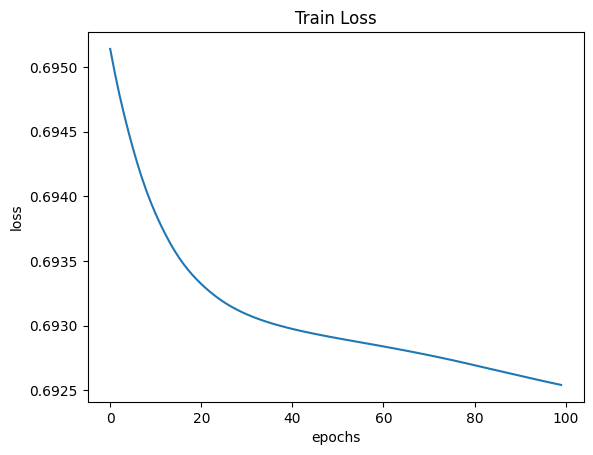

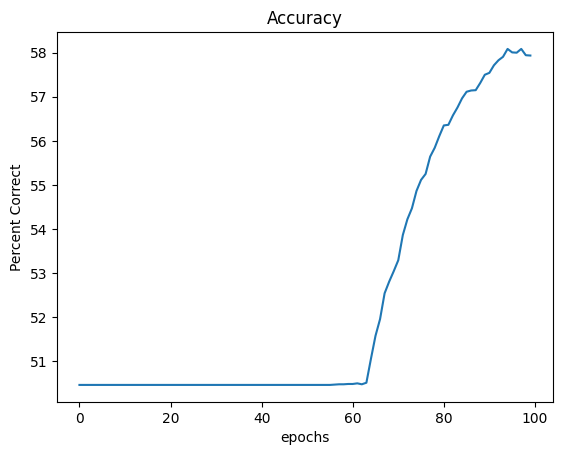

In [43]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(test_loss_a)
plt.title("Train Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.figure(2)
plt.plot(correct_a)
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("Percent Correct")

Text(0.5, 1.0, 'Train Data Evaluation | % Correct = 56.0')

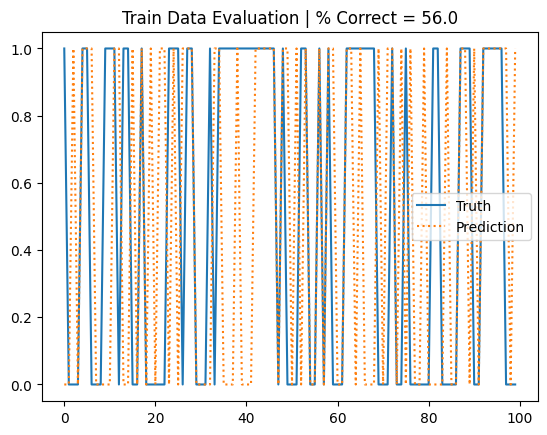

In [44]:
import numpy as np
import matplotlib.pyplot as plt

sample_num = 0
truth_arr = []
pred_arr = []

while(sample_num < 100):
  # print(train_tensor[sample_num].unsqueeze(0))

  truth = int(train_df.iloc[sample_num][12])
  # print("Cardiac disease:", train_df.iloc[sample_num])

  with torch.no_grad():
    r = model(train_tensor[sample_num].unsqueeze(0))

  pred = torch.argmax(r).item()
  # print('Prediction:', torch.argmax(r).item())

  truth_arr.append(truth)
  pred_arr.append(pred)

  sample_num += 1

pred_arr = np.array(pred_arr)
truth_arr = np.array(truth_arr)
diff = pred_arr - truth_arr
percent_correct = round(np.sum(diff == 0) / len(diff) * 100, 2)

plt.figure(1)
plt.plot(truth_arr, label="Truth")
plt.plot(pred_arr, linestyle = ":", label="Prediction")
plt.legend()
plt.title("Train Data Evaluation | % Correct = " + str(percent_correct))



Text(0.5, 1.0, 'Test Data Evaluation | % Correct = 54.0')

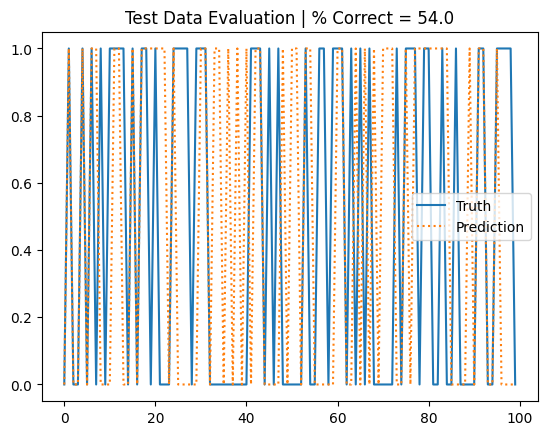

In [45]:
import numpy as np

sample_num = 0
truth_arr = []
pred_arr = []

while(sample_num < 100):
  # print(test_tensor[sample_num].unsqueeze(0))

  truth = int(test_df.iloc[sample_num][12])
  # print("Cardiac disease:", test_df.iloc[sample_num])

  with torch.no_grad():
    r = model(test_tensor[sample_num].unsqueeze(0))

  pred = torch.argmax(r).item()
  # print('Prediction:', torch.argmax(r).item())

  truth_arr.append(truth)
  pred_arr.append(pred)

  sample_num += 1

pred_arr = np.array(pred_arr)
truth_arr = np.array(truth_arr)
diff = pred_arr - truth_arr
percent_correct = round(np.sum(diff == 0) / len(diff) * 100, 2)

plt.figure(1)
plt.plot(truth_arr, label="Truth")
plt.plot(pred_arr, label="Prediction", linestyle = ":")
plt.legend()
plt.title("Test Data Evaluation | % Correct = " + str(percent_correct))

